# Text Classification

### Loadin Libraries

In [86]:
# Numerical Computing
import numpy as np
# Data Manipulation
import pandas as pd

# Scikit-Learn
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

# Data Visualization
import matplotlib.pyplot as plt
# Warnings
import warnings
# PyTorch
import torch
import torch.nn.functional as F
# Transformers
from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
from transformers import AutoModel

In [33]:
# Warnings
warnings.filterwarnings('ignore')
warnings.filterwarnings('ignore', category=UserWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

In [4]:
# !git clone https://github.com/nlp-with-transformers/notebooks.git
# %cd notebooks

from install import *
install_requirements(is_chapter2=True)

⏳ Installing base requirements ...
✅ Base requirements installed!
⏳ Installing Git LFS ...
✅ Git LFS installed!


In [6]:
import torch
print(torch.__version__)

2.2.0.post100


In [12]:
from utils import *
setup_chapter()

No GPU was detected! This notebook can be *very* slow without a GPU 🐢
Using transformers v4.37.2
Using datasets v2.19.0


### The Dataset

#### A First Look at Hugging Face Datasets

In [90]:
# Deprecatede version
from datasets import list_datasets

all_datasets = list_datasets()
print(f"There are {len(all_datasets)} datasets currently available on the Hub")
print(f"The first 10 are: {all_datasets[:10]}")

There are 136318 datasets currently available on the Hub
The first 10 are: ['acronym_identification', 'ade_corpus_v2',
'UCLNLP/adversarial_qa', 'aeslc', 'afrikaans_ner_corpus', 'ag_news',
'allenai/ai2_arc', 'air_dialogue', 'ajgt_twitter_ar', 'allegro_reviews']


In [94]:
# from huggingface_hub import list_datasets

# datasets_generator = list_datasets()

# all_datasets = list(datasets_generator)

# print(f"There are {len(all_datasets)} datasets currently available on the Hub")
# print(f"The first 10 are: {all_datasets[:10]}")

In [95]:
from datasets import load_dataset

emotions = load_dataset("emotion")

In [96]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [97]:
# Setting train dataset
train_ds = emotions["train"]
train_ds

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [98]:
# Checking length
len(train_ds)

16000

In [99]:
# Accessing index
train_ds[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [100]:
train_ds.column_names

['text', 'label']

In [101]:
# Accessing feature attributes as follow:
print(train_ds.features)

{'text': Value(dtype='string', id=None), 'label': ClassLabel(names=['sadness',
'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


In [102]:
print(train_ds[:5])

{'text': ['i didnt feel humiliated', 'i can go from feeling so hopeless to so
damned hopeful just from being around someone who cares and is awake', 'im
grabbing a minute to post i feel greedy wrong', 'i am ever feeling nostalgic
about the fireplace i will know that it is still on the property', 'i am feeling
grouchy'], 'label': [0, 0, 3, 2, 3]}


In [103]:
print(train_ds["text"][:5])

['i didnt feel humiliated', 'i can go from feeling so hopeless to so damned
hopeful just from being around someone who cares and is awake', 'im grabbing a
minute to post i feel greedy wrong', 'i am ever feeling nostalgic about the
fireplace i will know that it is still on the property', 'i am feeling grouchy']


### Sidebar: What If My Dataset Is Not on the Hub?

In [104]:
# The original URL used in the book is no longer available, so we use a different one
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
!wget {dataset_url}

--2024-04-24 12:02:12--  https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt
Resolving huggingface.co (huggingface.co)... 2600:9000:20f4:4200:17:b174:6d00:93a1, 2600:9000:20f4:3a00:17:b174:6d00:93a1, 2600:9000:20f4:3e00:17:b174:6d00:93a1, ...
Connecting to huggingface.co (huggingface.co)|2600:9000:20f4:4200:17:b174:6d00:93a1|:443... connected.
HTTP request sent, awaiting response... 

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


200 OK
Length: 1658616 (1.6M) [text/plain]
Saving to: ‘train.txt.1’

train.txt.1         100%[===================>]   1.58M  9.09MB/s    in 0.2s    

2024-04-24 12:02:13 (9.09 MB/s) - ‘train.txt.1’ saved [1658616/1658616]



In [105]:
!head -n 1 train.txt

i didnt feel humiliated;sadness


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


In [106]:
# Performed locally as follow:
emotions_local = load_dataset("csv", data_files="train.txt", sep=";", 
                              names=["text", "label"])

In [107]:
# Performed remotely as follow:
dataset_url = "https://huggingface.co/datasets/transformersbook/emotion-train-split/raw/main/train.txt"
emotions_remote = load_dataset("csv", data_files=dataset_url, sep=";", 
                               names=["text", "label"])

### From Datasets to DataFrames

In [108]:
# Setting DataFrame as follow:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


#### Setting proper label's cardinality

In [109]:
# Switching procedure from integer to string as follow:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


### Looking at The Class Distribution

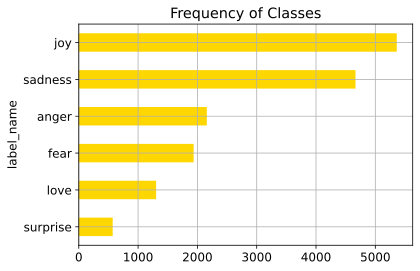

In [110]:
# Checking on example's distribution as follow:
df["label_name"].value_counts(ascending=True).plot.barh(color='gold')
plt.title("Frequency of Classes")
plt.grid(True)
plt.show()

### How Long Are Our Tweets?

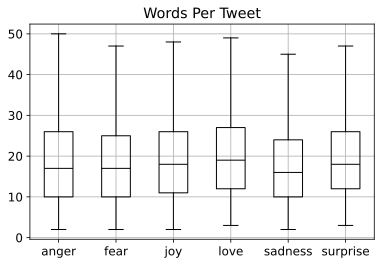

In [111]:
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.grid(True)
plt.show()

In [112]:
emotions.reset_format()

### From Text to Tokens

#### Character Tokenization

In [113]:
text = "Tokenizing text is a core task of NLP."
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ',
'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o',
'f', ' ', 'N', 'L', 'P', '.']


In [114]:
token2idx = {ch: idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9,
'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18,
'z': 19}


In [115]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7,
14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [116]:
categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [117]:
pd.get_dummies(categorical_df["Name"])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [118]:
# Setting & switching into PyTorch tensor
input_ids = torch.tensor(input_ids)
# One-hot encoding as follows:
one_hot_encodings = F.one_hot(input_ids, num_classes=len(token2idx))
one_hot_encodings.shape

torch.Size([38, 20])

In [119]:
# First (1) vector examination 
print(f"Token: {tokenized_text[0]}")
print(f"Tensor index: {input_ids[0]}")
print(f"One-hot: {one_hot_encodings[0]}")

Token: T
Tensor index: 5
One-hot: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


#### Word Tokenization

In [120]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


#### Subword Tokenization

In [121]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

In [122]:
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [123]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953,
2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [124]:
# Switchin IDs into tokens as follows:
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl',
'##p', '.', '[SEP]']


In [125]:
print(tokenizer.convert_tokens_to_string(tokens))

[CLS] tokenizing text is a core task of nlp. [SEP]


In [126]:
tokenizer.vocab_size

30522

In [127]:
tokenizer.model_max_length

512

In [128]:
tokenizer.model_input_names

['input_ids', 'attention_mask']

#### Tokenizing The Whole Dataset

In [129]:
# Tokenize processing function as follows:
def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

In [130]:
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000,
2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300,
102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
1, 1]]}


In [131]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [132]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

In [133]:
print(emotions_encoded["train"].column_names)

['text', 'label', 'input_ids', 'attention_mask']


### Training a Text Classifier

#### Transformers as Feature Extractors
##### Using pretrained models

In [134]:
model_ckpt = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt).to(device)

#### Extracting the last hidden states

In [135]:
text = "this is a test"

inputs = tokenizer(text, return_tensors="pt")
print(f"Input tensor shape: {inputs['input_ids'].size()}")

Input tensor shape: torch.Size([1, 6])


In [136]:
inputs = {k:v.to(device) for k,v in inputs.items()}

with torch.no_grad():
    outputs = model(**inputs)
    
print(outputs)

BaseModelOutput(last_hidden_state=tensor([[[-0.1565, -0.1862,  0.0528,  ...,
-0.1188,  0.0662,  0.5470],
         [-0.3575, -0.6484, -0.0618,  ..., -0.3040,  0.3508,  0.5221],
         [-0.2772, -0.4459,  0.1818,  ..., -0.0948, -0.0076,  0.9958],
         [-0.2841, -0.3917,  0.3753,  ..., -0.2151, -0.1173,  1.0526],
         [ 0.2661, -0.5094, -0.3180,  ..., -0.4203,  0.0144, -0.2149],
         [ 0.9441,  0.0112, -0.4714,  ...,  0.1439, -0.7288, -0.1619]]]),
hidden_states=None, attentions=None)


In [137]:
outputs.last_hidden_state.size()

torch.Size([1, 6, 768])

In [138]:
outputs.last_hidden_state[:,0].size()

torch.Size([1, 768])

In [139]:
# New hidden state column storage 
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items() 
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [140]:
import torch
print(torch.__version__)

2.2.0.post100


In [143]:
# emotions_encoded.set_format("torch", 
#                             columns=["input_ids", "attention_mask", "label"])

In [144]:
#hide_output
# emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

In [145]:
# emotions_hidden["train"].column_names

##### Creating a feature matrix